## VAE

Prepare mnist data:

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
# load data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [ ]:
(x_train.shape, y_train.shape), (x_test.shape, y_test.shape), np.max(x_train[0])

(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)), 255)

In [ ]:
x_train_2 = x_train[:,:,:,None] / 255
x_test_2 = x_test[:,:,:,None] / 255

## 1) Model 1

### 1.1) Encoder part 
Using the functional API of keras to write an encoder model called `enc` which has:
+ An input layer for mnist images  
+ 3 convolutional layers of shape: (None, 28, 28, 32), (None, 14, 14, 32), (None, 7, 7, 32)
+ 1 Flatten layer
+ An output of 2 dimensions

Do not use Sequential model here, use the following syntasis (of course it is possible to use Sequential model as we did before, but when we go to the next exercises, where we have variational autoencoders, the model is not sequential anymore and it will not be possible):
- x = keras.Input(shape = ...)
- x = (...)(x)     #layer 1
- x = (...)(x)     #layer 2
- ...
- in the end use enc = keras.Model(...)

Use .summary() to get the shapes of your layers, I expect you to have: 

(None, 28, 28, 1) $\to$ (None, 28, 28, 32) $\to$ (None, 14, 14, 32) $\to$ (None, 7, 7, 32) $\to$ (None, 1568) $\to$ (None, 2)

In [ ]:
#encoder
enc_input = keras.Input(shape=(28, 28, 1))
x = enc_input
x = keras.layers.Conv2D(filters=32, kernel_size=4, strides=1, padding='same',
                       activation='relu')(x)
x = keras.layers.Conv2D(filters=32, kernel_size=2, strides=2,
                       activation='relu')(x)
x = keras.layers.Conv2D(filters=32, kernel_size=2, strides=2,
                       activation='relu')(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(2)(x)

enc = keras.Model(inputs=enc_input, outputs=x)
enc.summary()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        544       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4128      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          4128      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3138      
Total params: 11,938
Trainable params: 11,938
Non-trainable params: 0
____________________________________________________

###1.2) Decoder part 
Write a decoder model called `dec` with:
+ Input of 2 dimensions
+ "Symmetric" to the above encoder
Note: Use `Conv2DTranspose` layers which is opposite to convolutional layers.

In [ ]:
enc.layers[-1].output_shape[1:]

(2,)

In [ ]:
# decoder
dec_input = keras.Input(shape=enc.layers[-1].output_shape[1:])
x = dec_input
x = keras.layers.Dense(1568)(x)
x = keras.layers.Reshape((7,7,32))(x)
x = keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2,
                       activation='relu')(x)
x = keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2,
                       activation='relu')(x)
x = keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=1, padding='same')(x)

dec = keras.Model(inputs=dec_input, outputs=x)
dec.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1568)              4704      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 32)        4128      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 32)        4128      
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 1)         513       
Total params: 13,473
Trainable params: 13,473
Non-trainable params: 0
_______________________________________________________

Here we concatenate the 2 models `enc` and `dec`:

In [ ]:
# Composition
input_autoenc = enc.layers[0].input
x = enc.layers[-1].output
x = dec(x)
autoenc = keras.Model(input_autoenc, x)
autoenc.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        544       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        4128      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 32)          4128      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 3138      
_________________________________________________________________
model_5 (Model)              (None, 28, 28, 1)         1347

###1.3) Compilation
 Compile and train the `autoenc` model for several epochs (10 for example).

In [ ]:
autoenc.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse')
autoenc.fit(x = x_train_2, y= x_train_2, batch_size=32, epochs=10, 
            validation_data=(x_test_2, x_test_2))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 15s 246us/step - loss: 0.0516 - val_loss: 0.0469
Epoch 2/10
60000/60000 [==============================] - 14s 238us/step - loss: 0.0463 - val_loss: 0.0459
Epoch 3/10
60000/60000 [==============================] - 14s 236us/step - loss: 0.0450 - val_loss: 0.0449
Epoch 4/10
60000/60000 [==============================] - 14s 238us/step - loss: 0.0443 - val_loss: 0.0439
Epoch 5/10
60000/60000 [==============================] - 14s 237us/step - loss: 0.0438 - val_loss: 0.0437
Epoch 6/10
60000/60000 [==============================] - 14s 238us/step - loss: 0.0434 - val_loss: 0.0431
Epoch 7/10
60000/60000 [==============================] - 15s 257us/step - loss: 0.0431 - val_loss: 0.0431
Epoch 8/10
60000/60000 [==============================] - 16s 261us/step - loss: 0.0429 - val_loss: 0.0428
Epoch 9/10
60000/60000 [==============================] - 15s 257us/step - loss: 0.0426 - val_

### 1.4) Analysis 1

Write a code to: 
+ Randomly pick 25 input images 
+ Use the model above to make predictions 
+ Display those 25 images in a 5x5 grid
+ Similarly, display the 25 predictions in a 5x5 grid 

Compare the ground truth and the prediction.

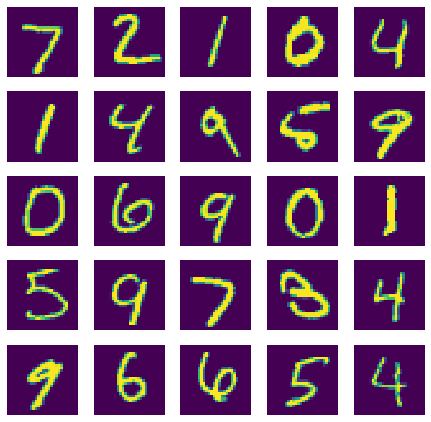

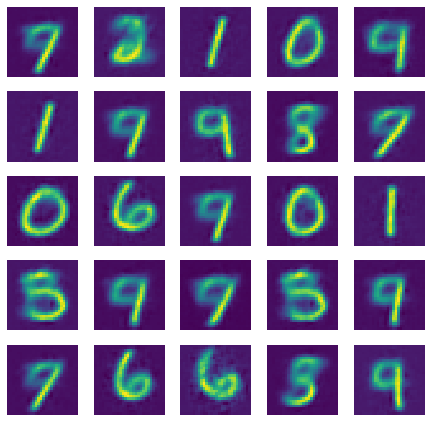

In [ ]:
# Analysis 
nb_show_root = 5

examples_show = x_test_2[: nb_show_root**2]
examples_show_labels = y_test[: nb_show_root**2]

# ground truth
fig = plt.figure(figsize=(7.5,7.5))
for i in range(nb_show_root ** 2):
  ax = fig.add_subplot(nb_show_root, nb_show_root, i+1)
  ax.axis('off')
  ax.imshow(examples_show[i,:,:,0])
fig.show()

# reconstruction
rec_images = autoenc.predict(examples_show)

fig = plt.figure(figsize=(7.5,7.5))
for i in range(nb_show_root ** 2):
  ax = fig.add_subplot(nb_show_root, nb_show_root, i+1)
  ax.axis('off')
  ax.imshow(rec_images[i,:,:,0])
fig.show()

### 1.5) Analysis 2

**Task**: Write a code to:
+ Randomly pick 7000 input images
+ Make predictions using the `enc` model
+ Plot those latent features with different colors based on their correct labels

Comment the result.

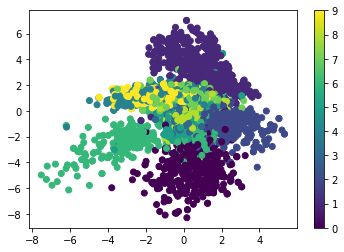

In [ ]:
# Analysis 2

nb_show = 7000

idx_show = np.random.choice(range(len(x_test_2)), nb_show)
examples_show = x_test_2[idx_show]
examples_show_labels = y_test[idx_show]

codes = enc.predict(examples_show)

plt.scatter(codes[:,0], codes[:,1], c=examples_show_labels)
plt.colorbar()
plt.show()

## 2) Model 2

### 2.1) Improvement of model 
Write another autoencoder with latent space of higher dimenion. Try several values of dimension. Do we obtain better reconstruction result?

**Extra task:** Try to modify the model (number of layers, shape, types of layers) a bit to see what happens. 

In [ ]:
d_z = 7
#encoder
enc_input = keras.Input(shape=(28, 28, 1))
x = enc_input
x = keras.layers.Conv2D(filters=32, kernel_size=4, strides=1, padding='same',
                       activation='relu')(x)
x = keras.layers.Conv2D(filters=32, kernel_size=2, strides=2,
                       activation='relu')(x)
x = keras.layers.Conv2D(filters=32, kernel_size=2, strides=2,
                       activation='relu')(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(d_z)(x)

enc = keras.Model(inputs=enc_input, outputs=x)

# decoder
dec_input = keras.Input(shape=enc.layers[-1].output_shape[1:])
x = dec_input
x = keras.layers.Dense(1568)(x)
x = keras.layers.Reshape((7,7,32))(x)
x = keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2,
                       activation='relu')(x)
x = keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2,
                       activation='relu')(x)
x = keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=1, padding='same')(x)

dec = keras.Model(inputs=dec_input, outputs=x)

# Composition
input_autoenc = enc.layers[0].input
x = enc.layers[-1].output
x = dec(x)
autoenc_2 = keras.Model(input_autoenc, x)
autoenc_2.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        544       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        4128      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 32)          4128      
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 10983     
_________________________________________________________________
model_8 (Model)              (None, 28, 28, 1)         2131

In [ ]:
autoenc_2.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse')
autoenc_2.fit(x = x_train_2, y= x_train_2, batch_size=32, epochs=10, 
            validation_data=(x_test_2, x_test_2))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 242us/step - loss: 0.0301 - val_loss: 0.0244
Epoch 2/10
60000/60000 [==============================] - 14s 234us/step - loss: 0.0238 - val_loss: 0.0229
Epoch 3/10
60000/60000 [==============================] - 14s 232us/step - loss: 0.0227 - val_loss: 0.0219
Epoch 4/10
60000/60000 [==============================] - 14s 235us/step - loss: 0.0220 - val_loss: 0.0214
Epoch 5/10
60000/60000 [==============================] - 15s 244us/step - loss: 0.0215 - val_loss: 0.0212
Epoch 6/10
60000/60000 [==============================] - 15s 253us/step - loss: 0.0212 - val_loss: 0.0208
Epoch 7/10
60000/60000 [==============================] - 15s 250us/step - loss: 0.0210 - val_loss: 0.0207
Epoch 8/10
60000/60000 [==============================] - 15s 250us/step - loss: 0.0208 - val_loss: 0.0204
Epoch 9/10
60000/60000 [==============================] - 15s 250us/step - loss: 0.0206 - val_

### 2.1) Analysis 1

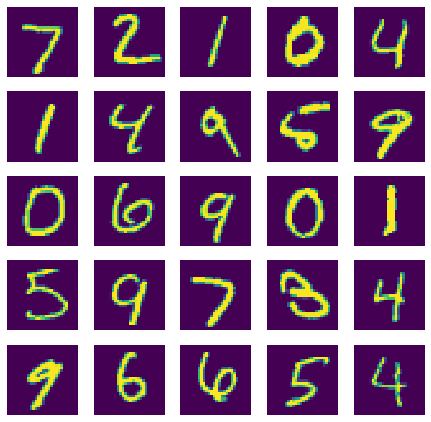

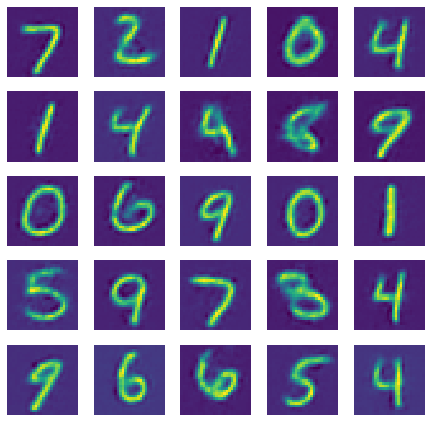

In [ ]:
## As we can see when the dimension of the latent space increases 
## the reconstruction quality gets better
# Analysis 1
nb_show_root = 5

examples_show = x_test_2[: nb_show_root**2]
examples_show_labels = y_test[: nb_show_root**2]

# ground truth
fig = plt.figure(figsize=(7.5,7.5))
for i in range(nb_show_root ** 2):
  ax = fig.add_subplot(nb_show_root, nb_show_root, i+1)
  ax.axis('off')
  ax.imshow(examples_show[i,:,:,0])
fig.show()

# reconstruction
rec_images = autoenc_2.predict(examples_show)

fig = plt.figure(figsize=(7.5,7.5))
for i in range(nb_show_root ** 2):
  ax = fig.add_subplot(nb_show_root, nb_show_root, i+1)
  ax.axis('off')
  ax.imshow(rec_images[i,:,:,0])
fig.show()

## 3) Variational autoencoders (VAE) 

###3.1) Encoder and decoder
Based on the AE with 2 latent dimension above, write an VAE with 2 latent dimension, called `vae`.
+ To write the sampling layer, you can use the `Lambda` layer with the sampling function below.
+ When you define the model, call the mean and the log of the variance as `muy` and `log_var` (we use log variance because it can take any value)
+ The outputs of the encoder should be the `muy`, the `log_var`, and the sample `z`
+ We will then feed `z` to the decoder.

The loss is defined below along with the compilation. Make sure we have `muy` and `log_var`. You can also try to define the loss yourself using keras backend.

In [ ]:
from keras import backend as K

def sampling(args):
  mu, log_var = args
  batch = K.shape(mu)[0]
  dim = K.shape(mu)[1]
  #dim = K.int_shape(z_mean)[1]
  
  epsilon = K.random_normal(shape=(batch, dim))
  return mu + K.exp(0.5 * log_var) * epsilon

In [ ]:
d_z = 2
#encoder
enc_input = keras.Input(shape=(28, 28, 1))
x = enc_input
x = keras.layers.Conv2D(filters=32, kernel_size=4, strides=1, padding='same',
                       activation='relu')(x)
x = keras.layers.Conv2D(filters=32, kernel_size=2, strides=2,
                       activation='relu')(x)
x = keras.layers.Conv2D(filters=32, kernel_size=2, strides=2,
                       activation='relu')(x)

x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)

mu = keras.layers.Dense(d_z)(x)
log_var = keras.layers.Dense(d_z)(x)

z = keras.layers.Lambda(function=sampling)([mu, log_var])

enc = keras.Model(enc_input, [mu, log_var, z], name='encoder')
# decoder
dec_input = keras.Input(shape=(d_z,))
x = dec_input
x = keras.layers.Dense(1568)(x)

x = keras.layers.Reshape((7,7,32))(x)
x = keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2,
                       activation='relu')(x)
x = keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2,
                       activation='relu')(x)
x = keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=1, padding='same',
                                activation='relu')(x)

dec = keras.Model(inputs=dec_input, outputs=x)

# Composition
vae_outputs = dec(enc(enc_input)[2])

vae = keras.Model(enc_input, vae_outputs)
vae.summary()



Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 21348     
_________________________________________________________________
model_10 (Model)             (None, 28, 28, 1)         13473     
Total params: 34,821
Trainable params: 31,685
Non-trainable params: 3,136
_________________________________________________________________


In [ ]:
enc.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 28, 28, 32)   544         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 14, 14, 32)   4128        conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 7, 7, 32)     4128        conv2d_11[0][0]                  
____________________________________________________________________________________________

In [ ]:
dec.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1568)              4704      
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 14, 14, 32)        4128      
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 32)        4128      
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 28, 28, 1)         513       
Total params: 13,473
Trainable params: 13,473
Non-trainable params: 0
______________________________________________________

In [ ]:
# define loss and compile
def vae_loss(y_true, y_pred):
  mse_loss = keras.losses.mean_squared_error(y_true, y_pred)
  kl_div = (K.square(mu) + K.exp(log_var) -1 - log_var ) / 2
  # trade off between mse and kl divergence
  return K.mean(mse_loss) + K.mean(kl_div) /28 /28
vae.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=vae_loss)

### 3.2) Training the model 
Train the model


In [ ]:
# train the model
vae.fit(x = x_train_2, y= x_train_2, batch_size=32, epochs=10, validation_data=(x_test_2, x_test_2))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 25s 410us/step - loss: 0.0558 - val_loss: 0.0531
Epoch 2/10
60000/60000 [==============================] - 24s 393us/step - loss: 0.0527 - val_loss: 0.0514
Epoch 3/10
60000/60000 [==============================] - 22s 366us/step - loss: 0.0521 - val_loss: 0.0510
Epoch 4/10
60000/60000 [==============================] - 22s 364us/step - loss: 0.0518 - val_loss: 0.0498
Epoch 5/10
60000/60000 [==============================] - 22s 368us/step - loss: 0.0515 - val_loss: 0.0509
Epoch 6/10
60000/60000 [==============================] - 22s 359us/step - loss: 0.0514 - val_loss: 0.0492
Epoch 7/10
60000/60000 [==============================] - 22s 365us/step - loss: 0.0512 - val_loss: 0.0490
Epoch 8/10
60000/60000 [==============================] - 22s 370us/step - loss: 0.0511 - val_loss: 0.0495
Epoch 9/10
60000/60000 [==============================] - 22s 365us/step - loss: 0.0510 - val_

### 3.3) Make prediction for 25 images
Use `vae` to make predictions with 25 images

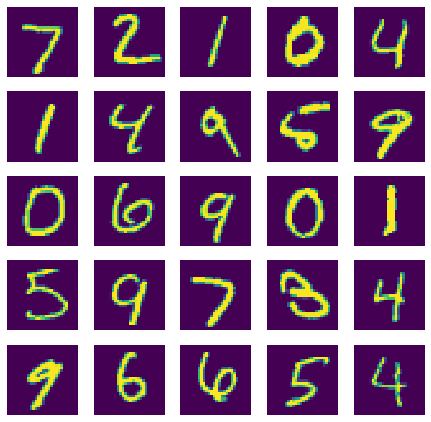

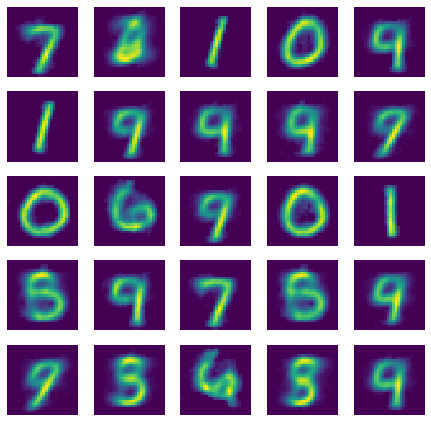

In [ ]:
# Analysis 
nb_show_root = 5

examples_show = x_test_2[: nb_show_root**2]
examples_show_labels = y_test[: nb_show_root**2]

# ground truth
fig = plt.figure(figsize=(7.5,7.5))
for i in range(nb_show_root ** 2):
  ax = fig.add_subplot(nb_show_root, nb_show_root, i+1)
  ax.axis('off')
  ax.imshow(examples_show[i,:,:,0])
fig.show()

# reconstruction
rec_images = vae.predict(examples_show)

fig = plt.figure(figsize=(7.5,7.5))
for i in range(nb_show_root ** 2):
  ax = fig.add_subplot(nb_show_root, nb_show_root, i+1)
  ax.axis('off')
  ax.imshow(rec_images[i,:,:,0])
fig.show()

### 3.4) Analysis 2
Use the encoder to predict 7000 images (sample z). Plot those predictions colored according to their labels. Then plot the "density" with respect to each dimension to see if it's approximately standard normal distribution.

Comment the results.

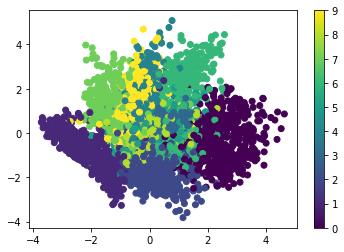

In [ ]:
# Analysis 2

nb_show = 7000

idx_show = np.random.choice(range(len(x_test_2)), nb_show)
examples_show = x_test_2[idx_show]
examples_show_labels = y_test[idx_show]

codes = enc.predict(examples_show)[2]

plt.scatter(codes[:,0], codes[:,1], c=examples_show_labels)
plt.colorbar()
plt.show()

(array([0.0169318 , 0.0489141 , 0.12006187, 0.26287052, 0.33966223,
        0.26389671, 0.08106743, 0.04241501, 0.01830003, 0.00307851]),
 array([-3.717134  , -2.8818505 , -2.046567  , -1.2112833 , -0.37599975,
         0.45928383,  1.2945673 ,  2.1298509 ,  2.9651346 ,  3.8004181 ,
         4.6357017 ], dtype=float32),
 <a list of 10 Patch objects>)

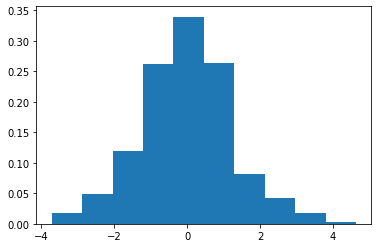

In [ ]:
plt.hist(codes[:,0], density=True)


(array([0.00289046, 0.0317951 , 0.11031933, 0.22529552, 0.41317561,
        0.207471  , 0.08173588, 0.03677311, 0.01268592, 0.00192698]),
 array([-3.8192203 , -2.929595  , -2.03997   , -1.1503447 , -0.26071954,
         0.62890565,  1.5185308 ,  2.408156  ,  3.2977812 ,  4.1874065 ,
         5.0770316 ], dtype=float32),
 <a list of 10 Patch objects>)

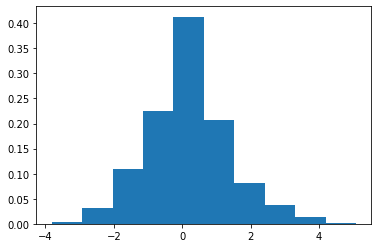

In [ ]:
plt.hist(codes[:,1], density=True)